# Imports


In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 373 µs (started: 2023-02-20 22:14:43 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense,
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.31 s (started: 2023-02-20 22:14:43 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'ResNet152V2'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'inverted' # o también inverted

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/' \
            + TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print()
print('versión Keras:', keras.__version__) # versión Keras: 2.8.0

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_{}/splits/inverted_otsu/

versión Keras: 2.11.0
time: 1.07 ms (started: 2023-02-20 22:14:46 +00:00)


In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 21.5 s (started: 2023-02-20 22:14:46 +00:00)


# Funciones

In [7]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG: regular o inverted

    Output:
    - np arrays for training and validation images
    '''

    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_8G.npz'
        train_name_labels = 'train_labels_8G.npz'
        val_name_img = 'val_imgs_8G.npz'
        val_name_labels = 'val_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_8G.npz'
        train_name_labels = 'train_inv_labels_8G.npz'
        val_name_img = 'val_inv_imgs_8G.npz'
        val_name_labels = 'val_inv_labels_8G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_8G.npz'
        test_name_labels = 'test_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_8G.npz'
        test_name_labels = 'test_inv_labels_8G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet152V2_8G = keras.applications.ResNet152V2(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet152V2_8G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    '''Recuperar una lista de resultados de la lista de datos de los conjuntos 
    de entrenamiento y pruebas para cada epoch de entrenamiento.
    '''

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG):
    '''Guardar el modelo en disco duro
    
    Args:
        -SIZE: 64, 96, 112 ó 127
        -TFM_PATH = Ruta en drive a la carpeta del TFM
        -custom_model: Modelo de Deep Learning
        -TYPE_IMG: regular o inverted
    '''
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl8_imgs{SIZE}_' \
                + TYPE_IMG +'__OTSU.h5'
    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH) # lo guarda es en el notebook

    print(f'------ Model Saved in {WEIGHTS_PATH}-------')


time: 6.5 ms (started: 2023-02-20 22:16:57 +00:00)


# Imgs 64x64

- Test Accuracy: 0.5869994163513184
- Test Loss: 2.1590676307678223
- time: 1h 14min 3s
- F1 score: 0.5859083184462146
- Precision score: 0.6091513065775107
- Recall:  0.5869994359842076
- Epoch: 50/50

## Cargar las imágenes

In [8]:
SIZE = 64 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_64/splits/inverted_otsu/
time: 999 µs (started: 2023-02-20 22:17:00 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 4.53 s (started: 2023-02-20 22:17:00 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)


time: 1.41 ms (started: 2023-02-20 22:17:05 +00:00)


## Preparar el modelo

In [11]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

234545216/234545216 [==============================] - 1s 0us/step
time: 8.2 s (started: 2023-02-20 22:17:05 +00:00)


In [12]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar el modelo

In [13]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 104s 26ms/step - loss: 5.8410 - sparse_categorical_accuracy: 0.0909 - val_loss: 5.2653 - val_sparse_categorical_accuracy: 0.1747
Epoch 2/50
3325/3325 [==============================] - 84s 25ms/step - loss: 4.8432 - sparse_categorical_accuracy: 0.2473 - val_loss: 4.6747 - val_sparse_categorical_accuracy: 0.2569
Epoch 3/50
3325/3325 [==============================] - 84s 25ms/step - loss: 4.3106 - sparse_categorical_accuracy: 0.3248 - val_loss: 4.2930 - val_sparse_categorical_accuracy: 0.3099
Epoch 4/50
3325/3325 [==============================] - 85s 26ms/step - loss: 3.9350 - sparse_categorical_accuracy: 0.3764 - val_loss: 4.0153 - val_sparse_categorical_accuracy: 0.3450
Epoch 5/50
3325/3325 [==============================] - 84s 25ms/step - loss: 3.6462 - sparse_categorical_accuracy: 0.4154 - val_loss: 3.7992 - val_sparse_categorical_accuracy: 0.3691
Epoch 6/50
3325/3325 [==============================] - 84s 25ms/step - loss: 3

In [14]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 521 ms (started: 2023-02-20 23:31:19 +00:00)


In [15]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 12s 22ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.5869994163513184
- Test Loss: 2.1590676307678223
- time: 
- F1 score: 0.5859083184462146
- Precision score: 0.6091513065775107
- Recall:  0.5869994359842076
- Epoch: 
*********************************************************************************************************************************
time: 23.7 s (started: 2023-02-20 23:31:19 +00:00)


## Graficando

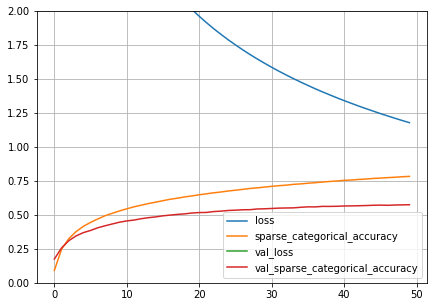

time: 271 ms (started: 2023-02-20 23:31:43 +00:00)


In [16]:
plot_loss(history)

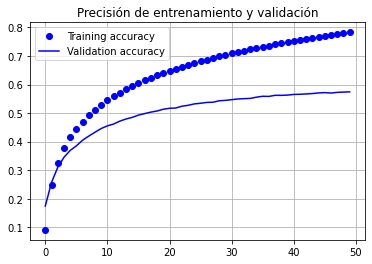

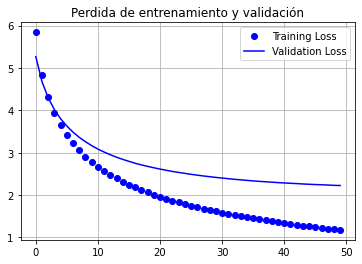

time: 385 ms (started: 2023-02-20 23:31:43 +00:00)


In [17]:
show_history(history)

In [18]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/inverted/model_resnet152v2_etl8_imgs64_inverted__OTSU.h5-------
time: 2.89 s (started: 2023-02-20 23:31:44 +00:00)


# Imgs 96x96

- Test Accuracy: 0.6848561763763428
- Test Loss: 1.6687047481536865
- time: 1h 17min 9s
- F1 score: 0.6853038926805649
- Precision score: 0.7040948627328873
- Recall:  0.6848561759729273
- Epoch: 50/50


## Cargar las imágenes

In [19]:
SIZE = 96 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

time: 624 µs (started: 2023-02-20 23:31:47 +00:00)


In [20]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 4.91 s (started: 2023-02-20 23:31:47 +00:00)


In [21]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)


time: 1.27 ms (started: 2023-02-20 23:31:52 +00:00)


## Preparar el modelo

In [22]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 4.47 s (started: 2023-02-20 23:31:52 +00:00)


In [23]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['concatenate_1[0][0]']          
                                                                                            

## Entrenar el modelo

In [24]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 106s 29ms/step - loss: 5.7597 - sparse_categorical_accuracy: 0.1105 - val_loss: 5.1534 - val_sparse_categorical_accuracy: 0.2132
Epoch 2/50
3325/3325 [==============================] - 94s 28ms/step - loss: 4.7212 - sparse_categorical_accuracy: 0.3025 - val_loss: 4.5359 - val_sparse_categorical_accuracy: 0.3104
Epoch 3/50
3325/3325 [==============================] - 95s 29ms/step - loss: 4.1517 - sparse_categorical_accuracy: 0.3922 - val_loss: 4.1174 - val_sparse_categorical_accuracy: 0.3703
Epoch 4/50
3325/3325 [==============================] - 95s 29ms/step - loss: 3.7369 - sparse_categorical_accuracy: 0.4553 - val_loss: 3.8025 - val_sparse_categorical_accuracy: 0.4119
Epoch 5/50
3325/3325 [==============================] - 94s 28ms/step - loss: 3.4109 - sparse_categorical_accuracy: 0.5017 - val_loss: 3.5554 - val_sparse_categorical_accuracy: 0.4425
Epoch 6/50
3325/3325 [==============================] - 93s 28ms/step - loss: 3

In [25]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 760 ms (started: 2023-02-21 00:49:08 +00:00)


In [26]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 12s 21ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6848561763763428
- Test Loss: 1.6687047481536865
- time: 
- F1 score: 0.6853038926805649
- Precision score: 0.7040948627328873
- Recall:  0.6848561759729273
- Epoch: 
*********************************************************************************************************************************
time: 24.3 s (started: 2023-02-21 00:49:09 +00:00)


## Graficando

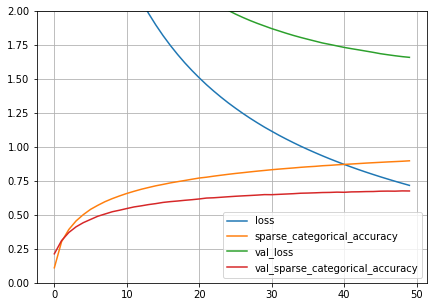

time: 211 ms (started: 2023-02-21 00:49:33 +00:00)


In [27]:
plot_loss(history)

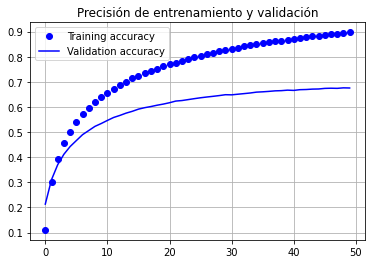

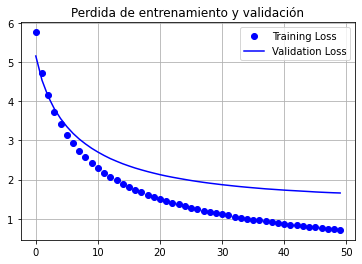

time: 988 ms (started: 2023-02-21 00:49:34 +00:00)


In [28]:
show_history(history)

In [29]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/inverted/model_resnet152v2_etl8_imgs96_inverted__OTSU.h5-------
time: 1.6 s (started: 2023-02-21 00:49:35 +00:00)


# Imgs 112x112

- Test Accuracy: 0.7069233059883118
- Test Loss: 1.5387126207351685
- time: 1h 26min 3s
- F1 score: 0.708228286291669
- Precision score: 0.7276294819462442
- Recall:  0.7069232938522279
- Epoch: 50/50

## Cargar imágenes

In [30]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 588 µs (started: 2023-02-21 00:49:37 +00:00)


In [31]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 5.82 s (started: 2023-02-21 00:49:37 +00:00)


In [32]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 1.19 ms (started: 2023-02-21 00:49:43 +00:00)


## Preparar el modelo

In [33]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 4.54 s (started: 2023-02-21 00:49:43 +00:00)


In [34]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate_2[0][0]']    

## Entrenar el modelo

In [35]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 118s 33ms/step - loss: 5.5148 - sparse_categorical_accuracy: 0.1162 - val_loss: 4.8242 - val_sparse_categorical_accuracy: 0.2172
Epoch 2/50
3325/3325 [==============================] - 104s 31ms/step - loss: 4.3548 - sparse_categorical_accuracy: 0.3113 - val_loss: 4.1715 - val_sparse_categorical_accuracy: 0.3307
Epoch 3/50
3325/3325 [==============================] - 105s 32ms/step - loss: 3.7519 - sparse_categorical_accuracy: 0.4153 - val_loss: 3.7483 - val_sparse_categorical_accuracy: 0.3891
Epoch 4/50
3325/3325 [==============================] - 103s 31ms/step - loss: 3.3237 - sparse_categorical_accuracy: 0.4849 - val_loss: 3.4288 - val_sparse_categorical_accuracy: 0.4449
Epoch 5/50
3325/3325 [==============================] - 105s 32ms/step - loss: 2.9928 - sparse_categorical_accuracy: 0.5367 - val_loss: 3.1829 - val_sparse_categorical_accuracy: 0.4749
Epoch 6/50
3325/3325 [==============================] - 105s 32ms/step - lo

In [36]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 921 ms (started: 2023-02-21 02:15:53 +00:00)


In [37]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 13s 22ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7069233059883118
- Test Loss: 1.5387126207351685
- time: 
- F1 score: 0.708228286291669
- Precision score: 0.7276294819462442
- Recall:  0.7069232938522279
- Epoch: 
*********************************************************************************************************************************
time: 25.2 s (started: 2023-02-21 02:15:54 +00:00)


## Graficando

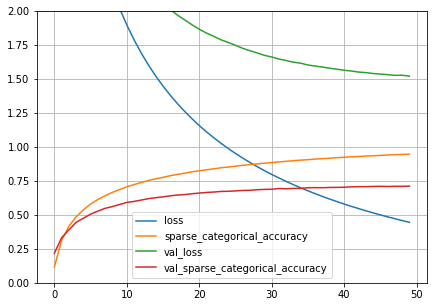

time: 207 ms (started: 2023-02-21 02:16:19 +00:00)


In [38]:
plot_loss(history)

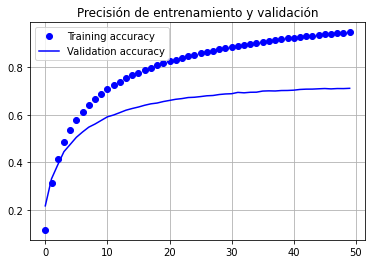

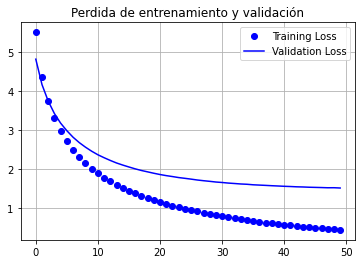

time: 363 ms (started: 2023-02-21 02:16:19 +00:00)


In [39]:
show_history(history)

In [40]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/inverted/model_resnet152v2_etl8_imgs112_inverted__OTSU.h5-------
time: 1.62 s (started: 2023-02-21 02:16:19 +00:00)


# Imgs 127x127

- Test Accuracy: 0.7423858046531677
- Test Loss: 1.2953965663909912
- time: 1h 21min 57s
- F1 score: 0.7430580973919791
- Precision score: 0.7580837134296053
- Recall:  0.7423857868020305
- Epoch: 50/50

## Cargar las imágenes

In [41]:
SIZE = 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 795 µs (started: 2023-02-21 02:16:21 +00:00)


In [42]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 6.95 s (started: 2023-02-21 02:16:21 +00:00)


In [43]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 1.24 ms (started: 2023-02-21 02:16:28 +00:00)


## Preparar el modelo

In [44]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 4.61 s (started: 2023-02-21 02:16:28 +00:00)


In [45]:
print(custom_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 127, 127, 3)  0           ['input_4[0][0]',                
                                                                  'input_4[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate_3[0][0]']    

## Entrenar el modelo

In [46]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 113s 31ms/step - loss: 5.0019 - sparse_categorical_accuracy: 0.1732 - val_loss: 4.1712 - val_sparse_categorical_accuracy: 0.2977
Epoch 2/50
3325/3325 [==============================] - 101s 30ms/step - loss: 3.6159 - sparse_categorical_accuracy: 0.4081 - val_loss: 3.4693 - val_sparse_categorical_accuracy: 0.4191
Epoch 3/50
3325/3325 [==============================] - 100s 30ms/step - loss: 2.9875 - sparse_categorical_accuracy: 0.5201 - val_loss: 3.0520 - val_sparse_categorical_accuracy: 0.4815
Epoch 4/50
3325/3325 [==============================] - 101s 30ms/step - loss: 2.5675 - sparse_categorical_accuracy: 0.5901 - val_loss: 2.7617 - val_sparse_categorical_accuracy: 0.5248
Epoch 5/50
3325/3325 [==============================] - 100s 30ms/step - loss: 2.2569 - sparse_categorical_accuracy: 0.6408 - val_loss: 2.5412 - val_sparse_categorical_accuracy: 0.5556
Epoch 6/50
3325/3325 [==============================] - 101s 30ms/step - lo

In [47]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.51 s (started: 2023-02-21 03:38:33 +00:00)


In [48]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 14s 26ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7423858046531677
- Test Loss: 1.2953965663909912
- time: 
- F1 score: 0.7430580973919791
- Precision score: 0.7580837134296053
- Recall:  0.7423857868020305
- Epoch: 
*********************************************************************************************************************************
time: 27.2 s (started: 2023-02-21 03:38:35 +00:00)


## Graficando


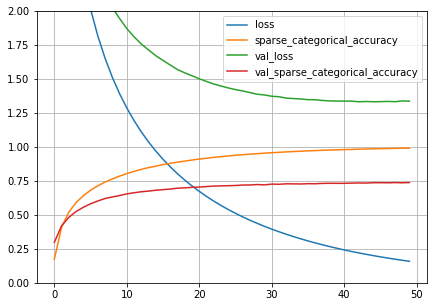

time: 205 ms (started: 2023-02-21 03:39:02 +00:00)


In [49]:
plot_loss(history)

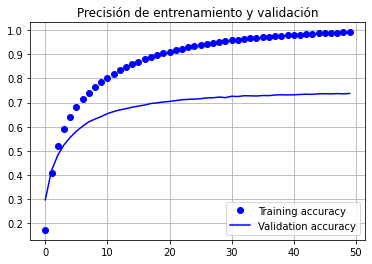

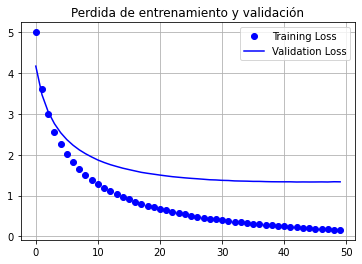

time: 409 ms (started: 2023-02-21 03:39:02 +00:00)


In [50]:
show_history(history)

In [51]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/inverted/model_resnet152v2_etl8_imgs127_inverted__OTSU.h5-------
time: 1.67 s (started: 2023-02-21 03:39:03 +00:00)


In [52]:
runtime.unassign()
#quit()

time: 708 ms (started: 2023-02-21 03:39:04 +00:00)
